In [59]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit


In [60]:
# #stupid
# def cartesian_spherical(v):
#     r = (v[0]**2 + v[1]**2 + v[2]**2)**.5
#     theta  = r*

6394 x 6628 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
Lithobrake event seen at 0.6596575577987409 hours
final distance is 17937.25450822219 km


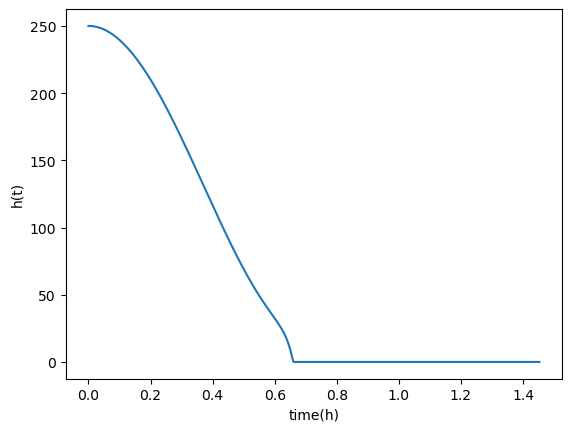

In [101]:
accel = 5e-5

#vostok atmospheric coefs
#2.3m sphere
c_d = 0.47
a_m = Math.pi*1.15**2/2270

atmosphere = COESA76()
density = 0


def constant_accel_factory(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        norm_v = (v[0]**2 + v[1]**2 + v[2]**2)**.5

        p = state[:3]
        alt = 10e-4*(np.linalg.norm(state)*10e2-Earth.R.value)*u.km#alt in km, not sure what these dumbass 1/10th of a metre units are
        density = 0*u.kg/(u.m**3)
        if(alt>0):
            density = atmosphere.properties(alt)[2]

        return -density.value *10e-2* v / norm_v
    

    return constant_accel


orbit = Orbit.circular(Earth,alt=250*u.km)

ov1 = orbit.v
prograde_norm= ((orbit.v.value*u.km/u.s)/((ov1[0]**2 + ov1[1]**2 + ov1[2]**2)**.5).value)
man = Maneuver((0 * u.s, -0.07*prograde_norm))
orbit = orbit.apply_maneuver(man)
print(orbit)

lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_total = 500
times = np.linspace(0, 1 * orbit.period, prop_total)
times
positions = propagate(
    orbit,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-11,
    ad=constant_accel_factory(accel),
    events = events
)
print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.h).value} hours")

#print(type(positions))

# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.h, 1 * orbit.period.to(u.h), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

#this dumbness only ~works cause oribt is equatorial
#acutlaly it doesnt quite work, final distance is correct, but only bc it loops (physically over the equator ) over itself ~ many times if multiple apogees exist

downrange_distance = (pos_spherical[positions.size-1].lon-pos_spherical[0].lon).value*Earth.R.to(u.km)
print(f"final distance is {downrange_distance}")

downrange = np.linspace(0*u.km,downrange_distance,prop_total)

plt.ylabel("h(t)")
# plt.xlabel("distance downrange, km")
plt.xlabel("time(h)")
plt.plot(tofs, pos_spherical.distance - Earth.R)
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
